In [1]:
%pip install adversarial-robustness-toolbox
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split
from art.attacks.evasion import FastGradientMethod
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import TensorFlowV2Classifier
from sklearn.metrics import accuracy_score

c:\Users\jupap\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = '../malimg_dataset/'

In [4]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 1 classes.


In [5]:
familias.class_indices

{'malimg_paper_dataset_imgs': 0}

In [6]:
imgs, labels = next(familias)

In [7]:
imgs.shape

(9339, 64, 64, 3)

In [8]:
labels.shape

(9339, 1)

In [9]:
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

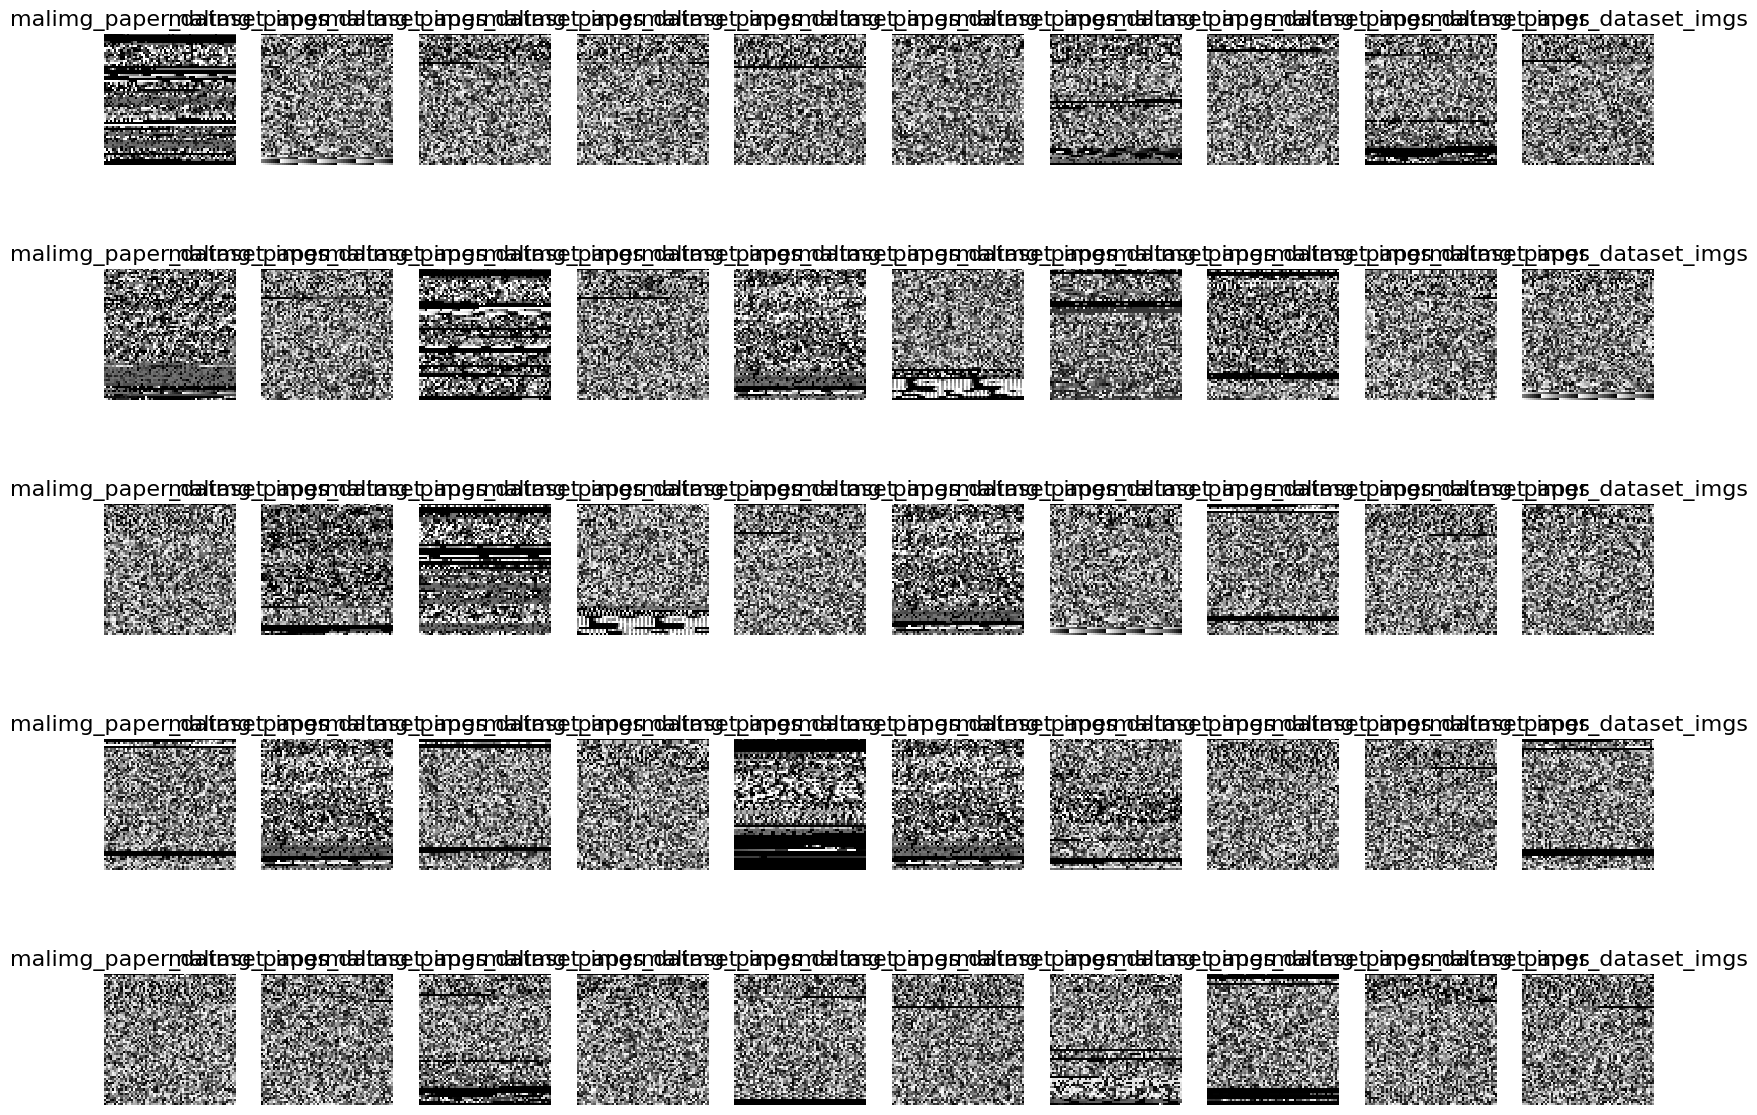

In [10]:
plots(imgs, titles = labels)

### Primera parte

In [11]:
# Create an image data generator for preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Load images
generator = datagen.flow_from_directory(
    directory=path,
    target_size=(64, 64),  # Resize images to 64x64
    batch_size=32,
    class_mode='categorical',  # or 'categorical' if more than two classes
    color_mode='rgb',
    shuffle=True
)

# Initialize lists to store the data
all_images = []
all_labels = []

# Iterate over the generator
for images, labels in generator:
    all_images.append(images)
    all_labels.append(labels)
    if len(all_images) * generator.batch_size >= generator.samples:
        break  # Ensure we don't go into an infinite loop

# Convert lists to numpy arrays
all_images = np.vstack(all_images)
all_labels = np.vstack(all_labels)

# Split data into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

Found 9339 images belonging to 1 classes.


In [12]:
def newANN():
    model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' if more than two classes
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class
    return model

In [22]:
model = newANN()

history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

# Evaluate the model
loss, acc = model.evaluate(train_images, train_labels)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

model.save("first.h5")

Epoch 1/5
234/234 [==============================] - 17s 72ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 1.8351e-22 - val_accuracy: 1.0000
Epoch 2/5
234/234 [==============================] - 16s 68ms/step - loss: 2.5450e-10 - accuracy: 1.0000 - val_loss: 1.8265e-22 - val_accuracy: 1.0000
Epoch 3/5
234/234 [==============================] - 16s 69ms/step - loss: 2.5235e-10 - accuracy: 1.0000 - val_loss: 1.8155e-22 - val_accuracy: 1.0000
Epoch 4/5
234/234 [==============================] - 17s 71ms/step - loss: 2.4972e-10 - accuracy: 1.0000 - val_loss: 1.8033e-22 - val_accuracy: 1.0000
Epoch 5/5
234/234 [==============================] - 3s 12ms/step - loss: 2.4381e-10 - accuracy: 1.0000
Loss: 2.438117763237102e-10
Accuracy: 1.0


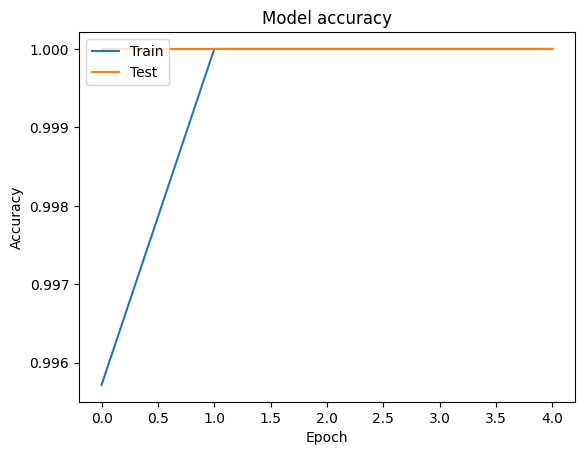

59/59 - 1s - loss: 3.3501e-23 - accuracy: 1.0000 - 671ms/epoch - 11ms/step
Test accuracy: 100.00%


In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc*100:.2f}%")

### Segunda parte

Cargando el modelo

In [15]:
model = load_model('first.h5')

classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=2,  # Adjust based on your number of classes
    input_shape=(64, 64, 3),
    loss_object=tf.keras.losses.BinaryCrossentropy(),  # Use CategoricalCrossentropy for multi-class
    clip_values=(0, 1)
)

Ataque de evasión

In [16]:
# Fast Gradient Sign Method (FGSM) Attack
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.1)  # eps controls the attack magnitude
x_test_adv_fgsm = fgsm_attack.generate(x=test_images)

In [17]:
# Evaluate the model on adversarial examples from FGSM
predictions_fgsm = classifier.predict(x_test_adv_fgsm)
accuracy_fgsm = np.mean(np.argmax(predictions_fgsm, axis=1) == np.argmax(test_labels, axis=1))
print(f"Accuracy on FGSM adversarial examples: {accuracy_fgsm * 100:.2f}%")


Accuracy on FGSM adversarial examples: 100.00%


Ataque de inferencia

In [18]:
model = load_model('first.h5')

train_predictions = model.predict(train_images)
test_predictions = model.predict(test_images)

59/59 [==============================] - 1s 12ms/step


In [19]:
# Calculate the maximum confidence in predictions for both sets
train_max_conf = np.max(train_predictions, axis=1)
test_max_conf = np.max(test_predictions, axis=1)

# Calculate a simple threshold as the mean confidence of the training set
threshold = np.mean(train_max_conf)

In [20]:
# Infer membership: if the confidence is greater than the threshold, it is likely a training sample
inferred_train_membership = train_max_conf > threshold
inferred_test_membership = test_max_conf > threshold

In [21]:
# Calculate the "accuracy" of membership inference
train_accuracy = np.mean(inferred_train_membership == True)
test_accuracy = np.mean(inferred_test_membership == False)

print(f"Training data inferred as training: {train_accuracy * 100:.2f}%")
print(f"Test data inferred as not training: {test_accuracy * 100:.2f}%")

Training data inferred as training: 0.00%
Test data inferred as not training: 100.00%
